In [25]:
# computes the metrics between GT shells and predicted shells
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from utils.utils import load_predictions, get_data, load_data, load_test_predictions, get_metrics, get_bbox_slices, get_bbox_margin, get_shells, compute_auc, get_path, train_test_auc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
root_path = get_path()
fig_path = os.path.join(root_path, "figures")

data_path = os.path.join(root_path, "RBC_labelled")

datasets = ["valid1", "valid2", "valid3"]

In [7]:
# load gt data
data_dict = {}
for dataset in datasets:
    imgs, gt, file_names = load_data(data_path, dataset)
    data_dict[dataset] = {"imgs": imgs,
                          "gt": gt,
                          "file_names": file_names}

In [8]:
# load prediction data
seed = 0
n_folds = 10
eval_str = "data_valid1_valid2_valid3_by_stack_mode_3D_iso_min_train_masks_0_seed_0_epoch_499_aniso_3.2"
for dataset in datasets:
    test_pred, test_idx = load_test_predictions(data_path,
                                     dataset,
                                     data_dict[dataset]["file_names"],
                                     eval_str,
                                     seed=seed,
                                     n_folds=n_folds)
    reverse_idx = np.argsort(test_idx)
    test_pred = test_pred[reverse_idx]
    data_dict[dataset]["pred"] = test_pred

In [9]:
# test shell functionality
img_id = 3
pred_shell = get_shells(data_dict["valid1"]["pred"][img_id], dilation_radius=0, erosion_radius=2)
gt_shell = get_shells(data_dict["valid1"]["gt"][img_id],  dilation_radius=0, erosion_radius=2)

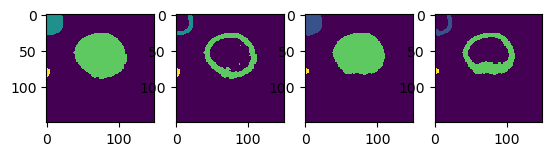

In [10]:
z=15
fig, ax = plt.subplots(1,4)
ax[0].imshow(data_dict["valid1"]["gt"][img_id][z], interpolation="none")
ax[1].imshow(gt_shell[z], interpolation="none")
ax[2].imshow(data_dict["valid1"]["pred"][img_id][z], interpolation="none")
ax[3].imshow(pred_shell[z], interpolation="none")

In [ ]:
# load membrane metrics

In [26]:
cmap = matplotlib.cm.get_cmap("tab10")
thresholds = np.arange(11)/ 10
stitch_threshold = 0.1
n_folds = 10
anisotropy = 3.2

Best method: cellpose_data_valid1_valid2_valid3_by_stack_mode_3D_iso_min_train_masks_0_seed_0_epoch_499
Best AUC: 0.625214392029327


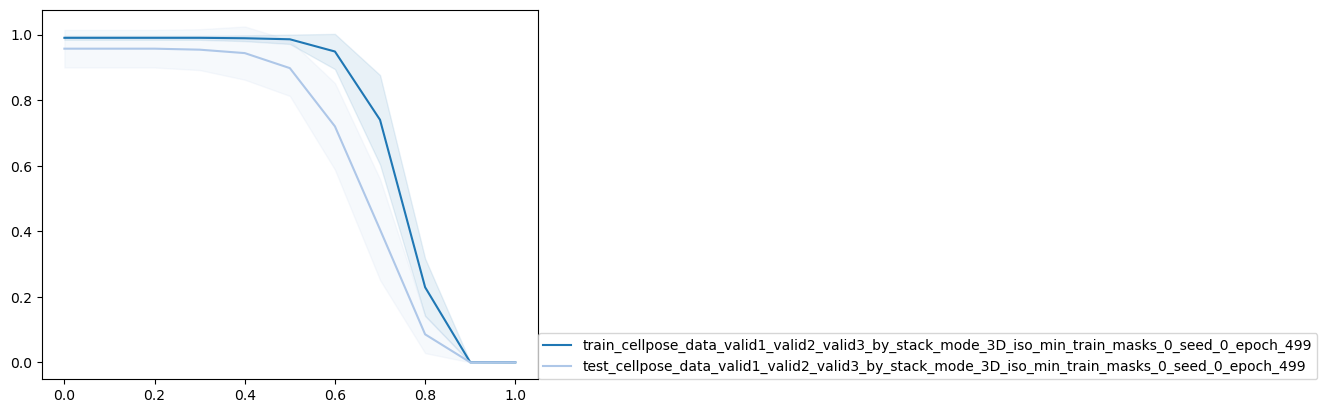

In [33]:
dataset = ["valid1", "valid2", "valid3"]

cv_model_names =["cellpose_data_valid1_valid2_valid3_by_stack_mode_3D_iso_min_train_masks_0_seed_0_epoch_499"
                 ]
ax, aps_train, aps_test = train_test_auc(cv_model_names,
                                         data_path,
                                         dataset,
                                         thresholds=thresholds,
                                         n_folds=n_folds,
                                         stitch_threshold=stitch_threshold,
                                         anisotropy=anisotropy,
                                         return_metrics=True,
                                         shells=True)

plt.savefig(os.path.join(fig_path,
                         "metric_RBC_membrane_before_pp.pdf"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200)

np.save(os.path.join(fig_path, "metric_RBC_membrane_before_pp_split_fold_threshold.npy"),
        np.array(np.concatenate([aps_train, aps_test])))

In [ ]:
# check if other shell widths and positions improve the metric (which they won't)

In [34]:
# compute dilation and erosion radii fo a given shell with and position
def get_d_e_radii(width, excess_dilation):
    d_radius = np.ceil(width / 2) + excess_dilation
    e_radius = np.floor(width / 2) - excess_dilation

    d_radius = int(d_radius)
    e_radius = int(e_radius)

    assert d_radius + e_radius == width

    return d_radius, e_radius




In [35]:
get_d_e_radii(1, -2)

(-1, 2)

In [36]:
%%time
# varies position and width of the gt and pred shell jointly, will always favour wide shells
shell_widths = [1, 2, 3, 4]
excess_dilations = [-1, 0, 1]


shell_aucs = np.zeros(shape=(len(shell_widths), len(excess_dilations)))


for i, width in enumerate(shell_widths):
    for j, excess_dilation in enumerate(excess_dilations):
        d_radius, e_radius = get_d_e_radii(width, excess_dilation)
        gt_d_radius, gt_e_radius = get_d_e_radii(width, 0)
        for dataset in data_dict.keys():
            shell_segs = []
            for seg in data_dict[dataset]["pred"]:
                shell_segs.append(get_shells(seg, erosion_radius=e_radius, dilation_radius=d_radius))
            data_dict[dataset]["pred_shell"] = np.stack(shell_segs)

            gt_shell_segs = []
            for seg in data_dict[dataset]["gt"]:
                gt_shell_segs.append(get_shells(seg, erosion_radius=gt_e_radius, dilation_radius=gt_d_radius))
            data_dict[dataset]["gt_shell"] = np.stack(gt_shell_segs)

        shell_aucs[i,j] = compute_auc(data_dict, stage="pred_shell", gt_stage="gt_shell")

CPU times: user 5min 25s, sys: 675 ms, total: 5min 26s
Wall time: 5min 27s


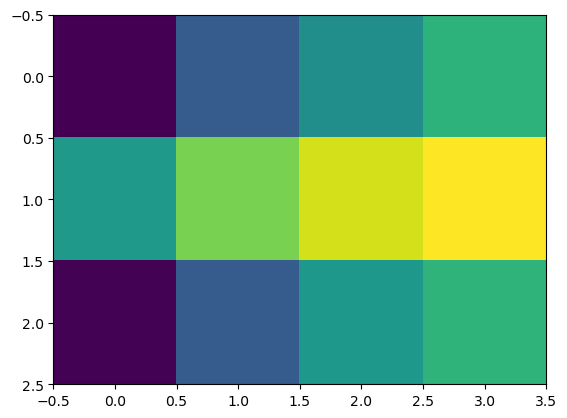

In [37]:
plt.imshow(shell_aucs.T)

--> increasing the width of both the pred and gt shell always improves the results. Not shifting the shell inwards or outwards gives the best results

In [38]:
%%time

# fix GT shell narrowly at 2 pix
shell_widths = [1, 2, 3, 4]
excess_dilations = [-1, 0, 1]


shell_aucs = np.zeros(shape=(len(shell_widths), len(excess_dilations)))


for i, width in enumerate(shell_widths):
    for j, excess_dilation in enumerate(excess_dilations):
        d_radius, e_radius = get_d_e_radii(width, excess_dilation)
        gt_d_radius, gt_e_radius = get_d_e_radii(2, 0)
        for dataset in data_dict.keys():
            shell_segs = []
            for seg in data_dict[dataset]["pred"]:
                shell_segs.append(get_shells(seg, erosion_radius=e_radius, dilation_radius=d_radius))
            data_dict[dataset]["pred_shell"] = np.stack(shell_segs)

            gt_shell_segs = []
            for seg in data_dict[dataset]["gt"]:
                gt_shell_segs.append(get_shells(seg, erosion_radius=gt_e_radius, dilation_radius=gt_d_radius))
            data_dict[dataset]["gt_shell"] = np.stack(gt_shell_segs)

        shell_aucs[i,j] = compute_auc(data_dict, stage="pred_shell", gt_stage="gt_shell")

CPU times: user 4min, sys: 476 ms, total: 4min 1s
Wall time: 4min 1s


([<matplotlib.axis.XTick at 0x7f82265954f0>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

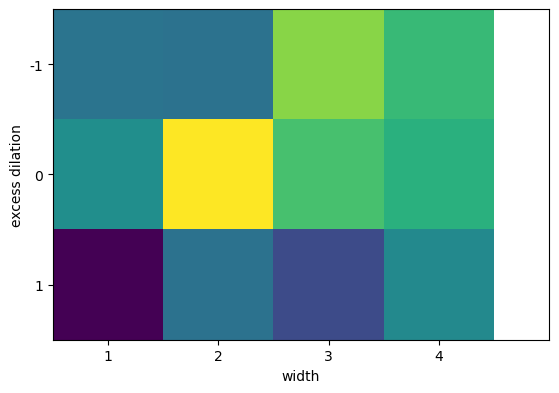

In [39]:
plt.imshow(shell_aucs.T)
plt.xlabel("width")
plt.xticks(shell_widths)

plt.ylabel("excess dilation")
plt.yticks([0, 1, 2], excess_dilations)
plt.xticks([0,1,2,3], shell_widths )

--> dilation_radius = 1 = erosion_radius seems best

In [40]:
print(shell_aucs)

[[0.30038016 0.35892961 0.09819714]
 [0.29621506 0.62611367 0.29725047]
 [0.53310468 0.47255529 0.21815868]
 [0.45445698 0.43235116 0.34661683]]
